In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('Set2')

SMALL_SIZE = 10
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\n",
plt.rc('figure', dpi=120)

In [2]:
df = pd.read_csv('../data/paysim.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [3]:
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1. EDA

CASH_OUT    0.35
PAYMENT     0.34
CASH_IN     0.22
TRANSFER    0.08
DEBIT       0.01
Name: type, dtype: float64


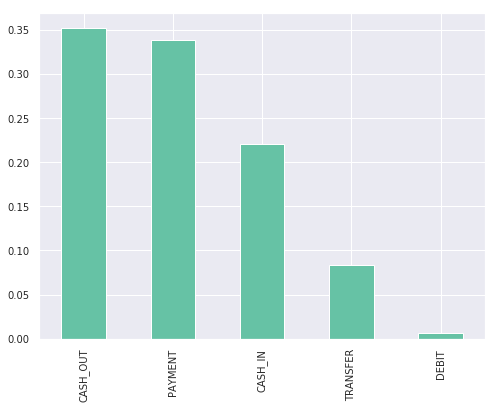

In [4]:
# Type of transactions

print(round(df.type.value_counts(normalize=True),2))
df.type.value_counts(normalize=True).plot(kind='bar', figsize=(8,6))

In [5]:
# Let's check TP, FP, TN, FN

is_fraud = df['isFraud']==1
is_flagged = df['isFlaggedFraud']==1

true_positive = df[is_fraud & is_flagged]
false_positive = df[~is_fraud & is_flagged]
true_negative = df[~is_fraud & ~is_flagged]
false_negative = df[is_fraud & ~is_flagged]

In [6]:
print(true_positive.shape)
print(false_positive.shape)
print(true_negative.shape)
print(false_negative.shape)

(16, 11)
(0, 11)
(6354407, 11)
(8197, 11)


NOTE:
- There are no false_positives
- There are many false_negatives; detection failed

## Let's take a look at the characteristics of the detected frauds (true positives)

In [7]:
print(f'Typical fraud transaction type(s): {true_positive.type.unique()}')

Typical fraud transaction type(s): ['TRANSFER']


In [8]:
def get_names_with_false_transfer(data):
    Difference_Orig = data['oldbalanceOrg'] - data['newbalanceOrig']
    Difference_Dest = data['oldbalanceDest'] - data['newbalanceDest']

    try:
        data['type'] == 'TRANSFER'
    except:
        pass
    # If transaction amount is not equal to the difference in balances of origin and destination
    suspicious_names = []
    if (data['amount'] != Difference_Orig).any() and (data['amount'] != Difference_Dest).any():
        suspicious_names += [name for name in data.nameOrig if name not in suspicious_names]
        suspicious_names += [name for name in data.nameDest if name not in suspicious_names]
    print(f'Fraud alert!!!')
    return list(set(suspicious_names))
    

In [9]:
suspicious_names = get_names_with_false_transfer(true_positive)
suspicious_names

Fraud alert!!!


['C1892216157',
 'C917414431',
 'C639921569',
 'C1869569059',
 'C908544136',
 'C2140038573',
 'C1100697970',
 'C661958277',
 'C1366804249',
 'C1806199534',
 'C193696150',
 'C1308068787',
 'C452586515',
 'C724693370',
 'C1395467927',
 'C1100582606',
 'C1035541766',
 'C728984460',
 'C689608084',
 'C19004745',
 'C1147517658',
 'C1909486199',
 'C992223106',
 'C1109166882',
 'C1684585475',
 'C1770418982',
 'C1861208726',
 'C484597480',
 'C891140444',
 'C1082139865',
 'C786455622',
 'C1392803603']

In [10]:
# Check other transaction activities of these suspicious individuals

def suspicious_transactions_by_name(data, names_list):
    suspicious_records = pd.DataFrame()
    for name in names_list:
        name_matched = data[(data['nameOrig']==name) | (data['nameDest']==name)]
        suspicious_records = suspicious_records.append(name_matched)
    return suspicious_records

In [11]:
# Let's see if these suspicious names appeared in the rest of the dataset (not true positives)

not_true_positive = df[~is_fraud | ~is_flagged]
len(not_true_positive)

6362604

In [12]:
suspicious_names_records = suspicious_transactions_by_name(not_true_positive, suspicious_names)
print(suspicious_names_records.shape)
suspicious_names_records

(8, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2854045,227,TRANSFER,760102.98,C1849800539,4050.00,0.00,C639921569,0.00,760102.98,0,0
3624889,274,CASH_IN,244597.73,C2127246739,8122859.99,8367457.72,C639921569,760102.98,515505.26,0,0
3812008,281,CASH_OUT,378860.57,C2043953867,637.00,0.00,C639921569,515505.26,894365.83,0,0
4265006,307,CASH_OUT,57467.33,C1001354003,5890.00,0.00,C639921569,894365.83,951833.16,0,0
4913476,349,CASH_OUT,159055.39,C1785841517,229.00,0.00,C639921569,951833.16,1110888.56,0,0
5048525,354,CASH_IN,122544.92,C1422777798,194.00,122738.92,C639921569,1110888.56,988343.63,0,0
6205345,586,CASH_IN,389744.76,C1080609672,671920.61,1061665.37,C639921569,988343.63,598598.87,0,0
5810706,401,CASH_OUT,31932.50,C1621471540,102191.00,70258.50,C1147517658,0.00,31932.50,0,0


In [13]:
# Let's see if the transaction amount look suspicious as well

get_names_with_false_transfer(suspicious_names_records)

Fraud alert!!!


['C2043953867',
 'C1001354003',
 'C1849800539',
 'C1147517658',
 'C1785841517',
 'C639921569',
 'C1621471540',
 'C1422777798',
 'C1080609672',
 'C2127246739']

- These were not fraud... but the amount of transaction doesn't match

## Let's look at the false negatives why they were not detected

In [14]:
print(f'Typical fraud transaction type(s): {false_negative.type.unique()}')

Typical fraud transaction type(s): ['TRANSFER' 'CASH_OUT']


In [15]:
# Get names appeared in these false transactions (when the action was a transfer)

names_not_detected = get_names_with_false_transfer(false_negative)
len(names_not_detected)

Fraud alert!!!


16350

In [16]:
# Let's see if the transaction amount of these undetcted individuals look suspicious as well

not_detected_but_suspicious = suspicious_transactions_by_name(false_negative, names_not_detected)
not_detected_but_suspicious.shape

(16394, 11)

In [17]:
df_list = [true_positive, false_negative, true_negative]
df_names = ['true_positive', 'false_negative', 'true_negative']

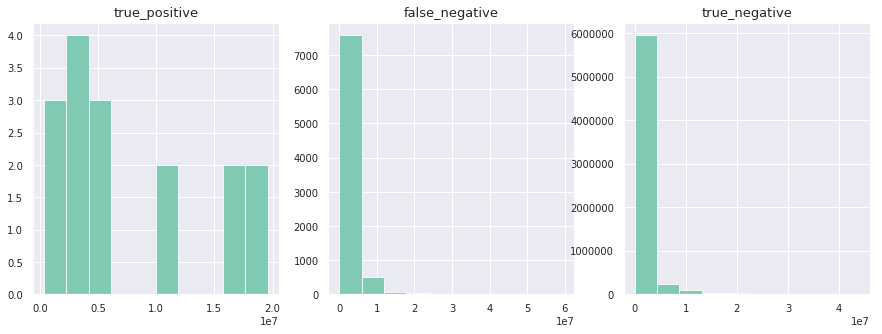

In [18]:
# oldbalanceOrig

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.oldbalanceOrg.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

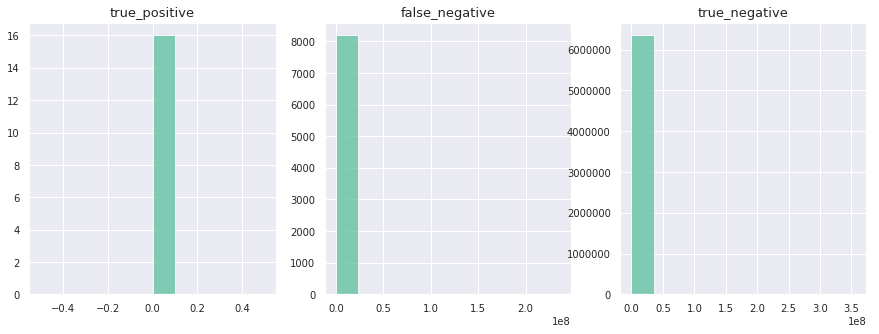

In [19]:
# oldbalanceDest

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.oldbalanceDest.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

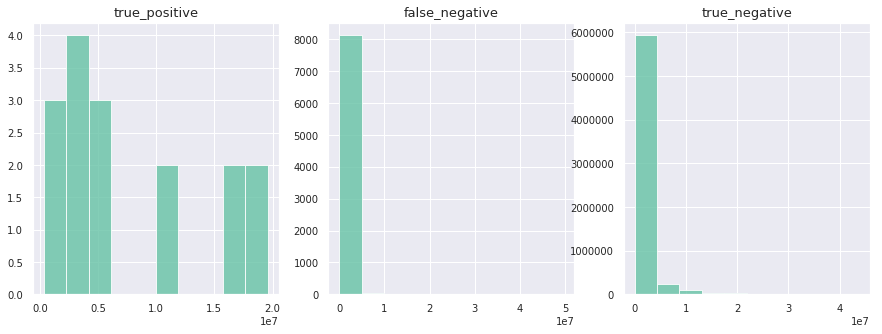

In [20]:
# newbalanceOrig

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.newbalanceOrig.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

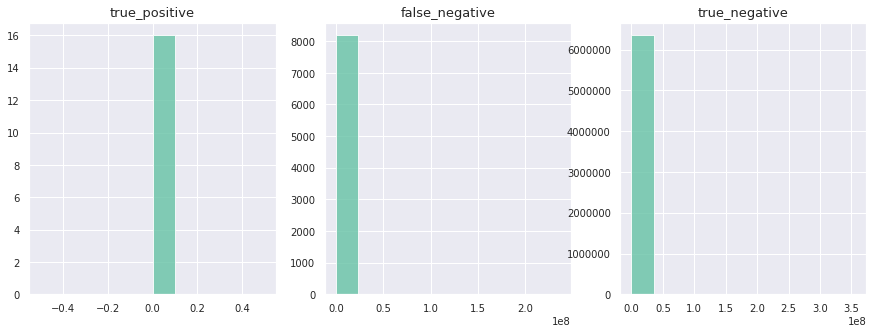

In [21]:
# newbalanceDest

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.newbalanceDest.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

Note:<br>
'Balance' columns can be confounding because false_negatives have similar distribution of the values with true_negatives.
Therefore, these features can be excluded for the future modeling.

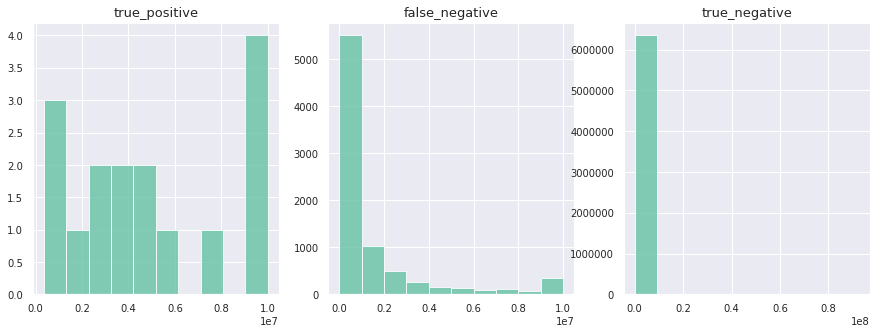

In [22]:
# amount of each transaction

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.amount.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

Note:
Amount distribution can be used to increase the detection rate?

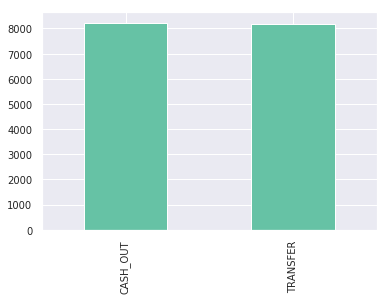

In [23]:
# What are the main transaction types of FNs?

not_detected_but_suspicious.type.value_counts().plot(kind='bar')

In [24]:
FN_transfer = not_detected_but_suspicious[not_detected_but_suspicious.type == 'TRANSFER']
FN_cashout = not_detected_but_suspicious[not_detected_but_suspicious.type == 'CASH_OUT']

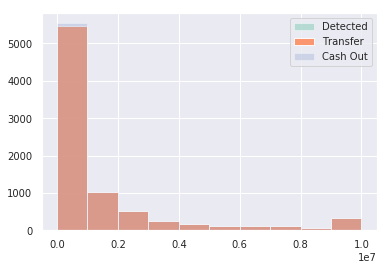

In [38]:
# Let's check the distribution of 'transaction amount' of every fraud actions

true_positive.amount.hist(label='Detected', alpha=.4)
FN_transfer.amount.hist(label='Transfer', alpha=.9)
FN_cashout.amount.hist(label='Cash Out', alpha=.3)

plt.legend()
plt.show()

Note: Fraud records show almost same distribution in their transaction amount

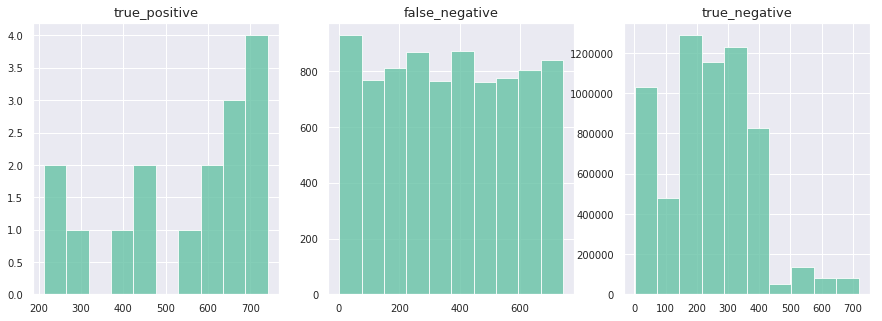

In [26]:
# Steps of transactions
# Steps: a unit of time. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, df in enumerate(df_list):
    g = df.step.hist(alpha=.8, ax=ax[i])
    g.set_title(df_names[i])
plt.show()

Note: Can steps be an important feature to detect frauds?